# 📘 Section 1. 워드클라우드란?

---

## 💡 개념 이해
워드클라우드는 **문서 속 단어의 출현 빈도**를 시각적으로 표현하는 그래픽입니다.  
- 단어 크기 → 자주 등장할수록 크게 표시  
- 단어 색상 → 의미·감정·테마를 시각적으로 표현  
- 단어 위치 → 랜덤 배치 (가시성을 위한 시각화 중심)

즉, **텍스트 데이터를 "눈으로 읽는 그래프"** 라고 할 수 있습니다.

---

## 🎯 학습 목표
1️⃣ Colab에서 데이터 파일 업로드 및 확인  
2️⃣ 한글 형태소 분석으로 단어 추출(KoNLPy)  
3️⃣ 단어 빈도 계산 및 정제  
4️⃣ Word Cloud로 단어 시각화  
5️⃣ 색상·모양·폰트 등 시각화 옵션 응용  

---

In [ ]:
!apt-get update
!apt-get install -y g++ openjdk-11-jdk python3-dev

!pip install --upgrade pip
!pip install --upgrade jpype1==1.4.1
!pip install --upgrade konlpy

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://cli.github.com/packages stable InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,876 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [

# 📦 Section 2. Colab 환경 설정 및 파일 업로드

In [ ]:
# Colab은 로컬 파일을 직접 읽을 수 없으므로, 파일 업로드를 통해 데이터 확보
from google.colab import files
import os

os.makedirs("data", exist_ok=True)  # data 폴더 생성

# 파일 업로드 (movie1_review.csv 업로드)
print("[STEP 1] movie1_review.csv 파일을 업로드하세요.")
uploaded = files.upload()

# 업로드된 파일을 data 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f"data/{filename}")

print("업로드 완료! data 폴더 안의 파일 목록:")
!ls data

[STEP 1] movie1_review.csv 파일을 업로드하세요.


Saving movie1_review.csv to movie1_review.csv
업로드 완료! data 폴더 안의 파일 목록:
movie1_review.csv


# 📚 Section 3. 필수 라이브러리 설치 및 폰트 설정

In [ ]:
!pip install konlpy wordcloud
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 한글 폰트 등록
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(path)
plt.rc('font', family='NanumGothic')

print("한글 폰트 및 라이브러리 설치 완료!")

Selecting previously unselected package fonts-nanum.
(Reading database ... 122832 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
한글 폰트 및 라이브러리 설치 완료!


# 📖 Section 4. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df = pd.read_csv("data/movie1_review.csv")
print("데이터 셋 크기:", df.shape)
print("컬럼명:", list(df.columns))
df.head()

데이터 셋 크기: (600, 1)
컬럼명: ['Review']


,Review
0,또 이어지나요! 잼있게 보았어요~^^
1,사운드가 웅장하고 아이맥스로도 보고싶어지네요.. 파트3도 기다려집니다
2,압도적인 체험 입니다!
3,방식과 템포의 유지속에 할애한 시간만큼의 납득에는 의문
4,IMAX로 보는 듄 : 파트2 볼만했어요.


# 🧠 Section 5. 형태소 분석 — 명사만 추출하기

---

## 📘 KoNLPy란?
KoNLPy는 **한국어 자연어 처리 라이브러리**로,  
문장을 형태소 단위로 나누어 단어를 추출할 수 있습니다.

- **명사(nouns)**: 핵심 키워드 추출용  
- **동사(verbs)**, **형용사(adjectives)**: 감정 분석 등 확장용  

이 실습에서는 영화 리뷰에서 **명사만 추출**하여 자주 등장하는 단어를 분석합니다.

In [ ]:
from konlpy.tag import Okt   # JVM이 필요 없는 형태소 분석기 → Colab에서 가장 안정적으로 동작
okt = Okt()  # 형태소 분석기 초기화

nouns = df["Review"].apply(okt.nouns)
nouns = nouns.explode()

print("명사 추출 완료!")
print(nouns.head())

명사 추출 완료!
0       또
1     사운드
1      웅장
1    아이맥스
1       도
Name: Review, dtype: object


# `explode()` 함수가 하는 일

## `explode()`란?
`explode()`는 **리스트 형태의 데이터를 세로로 펼치는 함수**입니다.

즉, 하나의 셀 안에 리스트가 들어있으면  
→ 그 리스트를 **여러 행으로 나누어 확장**합니다.

---

## 인덱스를 그대로 유지하는 이유
`explode()`는 원본 데이터의 행 정보(인덱스)를 보존합니다.

따라서:

- **0** → `df["Review"]`의 **0번 행에서 나온 명사**
- **1** → `df["Review"]`의 **1번 행에서 나온 명사들**
- 하나의 리뷰에서 명사가 여러 개 나오면  
  → 그 명사들은 **모두 같은 인덱스를 공유**합니다.

---

## 예시

### 원본 데이터
| index | Review               |
|-------|----------------------|
| 0     | 또 이어지나요! 잼있게 보았어요~^^      |
| 1     | 사운드가 웅장하고 아이맥스로도 보고싶어지네요.. 파트3도 기다려집니다    |

### 명사 추출 후 (리스트 형태)
| index | nouns                                 |
|-------|----------------------------------------|
| 0     | ["또"]                                 |
| 1     | ["사운드", "웅장", "아이맥스", "도"]   |

### `explode()` 적용 결과
| index | word     |
|-------|----------|
| 0     | 또        |
| 1     | 사운드    |
| 1     | 웅장      |
| 1     | 아이맥스  |
| 1     | 도        |

---

# 🧩 Section 6. 단어 펼치기 (explode) 및 전처리

In [ ]:
# 잘못 인식된 단어 교정
nouns[nouns == "모시"] = "티모시"
nouns[nouns == "IMAX"] = "아이맥스"
nouns[nouns == "파트3"] = "3편"

# 2글자 이상 단어만 남기기

# 추출된 명사(nouns)를 하나의 컬럼으로 가진 새 데이터프레임 생성
# 예: word 컬럼에 ["사운드", "웅장", "아이맥스", ...] 형태로 저장됨
df_word = pd.DataFrame({"word": nouns})

# 각 단어의 글자 수를 계산해서 len 컬럼에 저장
# 예: "사운드" → 3, "도" → 1
df_word["len"] = df_word["word"].str.len()

# 글자 수가 2 이상인 단어만 필터링
# 의미 없는 한 글자 단어(의미 없음, 조사 등)를 제거하기 위해 사용
df_word = df_word.query("len >= 2")

print("전처리 완료! 단어 개수:", len(df_word))
df_word.head()

전처리 완료! 단어 개수: 2661


,word,len
1,사운드,3.0
1,웅장,2.0
1,아이맥스,4.0
1,파트,2.0
2,압도,2.0


# 📊 Section 7. 단어 빈도 계산 및 불필요 단어 제거

In [ ]:
# 같은 단어 등장 횟수 집계

# word별로 그룹핑하여 같은 단어가 몇 번 등장했는지 세어줌
# count() → 현재 남아 있는 열(len)을 기준으로 등장 횟수를 계산함
df_word = df_word.groupby("word", as_index=False).count()

# len 컬럼의 이름을 count로 변경 (해당 숫자가 단어 등장 횟수이므로)
# sort_values() → 등장 횟수가 많은 단어 순으로 내림차순 정렬
df_word = df_word.rename(columns={"len": "count"}).sort_values("count", ascending=False)

# 불필요 단어 제거
del_idx = df_word.loc[df_word.word.isin(["영화", "편이", "영화관", "파트"])].index
df_word = df_word.drop(index=del_idx)

print("상위 단어 10개:")
print(df_word.head(10))

상위 단어 10개:
     word  count
504  아이맥스     62
808   티모시     40
98     기대     40
597    웅장     36
479    시간     32
686    정말     31
471   스토리     30
280    몰입     29
764    최고     28
5      가입     24


# 📈 Section 8. 상위 10개 단어 시각화

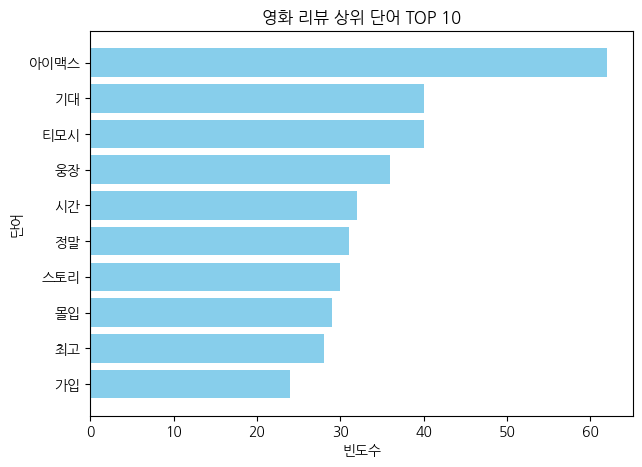

In [ ]:
import matplotlib.pyplot as plt   # ← 반드시 필요!

df_top10 = df_word.head(10).sort_values("count", ascending=True)

plt.figure(figsize=(7,5))
plt.barh(df_top10["word"], df_top10["count"], color="skyblue")
plt.title("영화 리뷰 상위 단어 TOP 10")
plt.xlabel("빈도수")
plt.ylabel("단어")
plt.show()

# ☁️ Section 9. 워드클라우드 기본 시각화

---

## ⚙️ WordCloud 주요 옵션 요약

| 옵션 | 설명 | 예시 |
|------|------|------|
| **font_path** | 한글 폰트 경로 지정 | `/usr/share/fonts/.../NanumGothic.ttf` |
| **width, height** | 이미지 크기 | `width=600, height=600` |
| **background_color** | 배경색 지정 | `'white'`, `'black'`, `'ivory'` |
| **colormap** | 색상 테마 | `'plasma'`, `'cool'`, `'rainbow'` |
| **mask** | 모양 지정 (numpy 이미지) | `mask=img` |
| **max_words** | 표시할 단어 수 제한 | `max_words=100` |
| **max_font_size** | 글자 최대 크기 | `max_font_size=120` |
| **prefer_horizontal** | 가로 글자 비율 | `prefer_horizontal=0.8` |
| **random_state** | 결과 고정 (재현성 확보) | `random_state=123` |

---

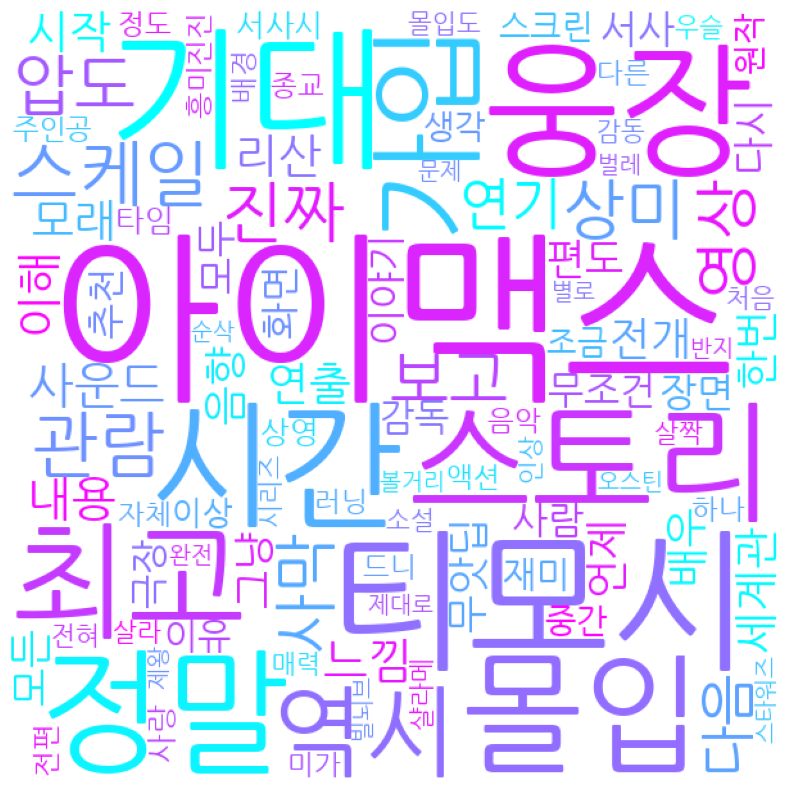

In [ ]:
from wordcloud import WordCloud

# 단어-빈도 딕셔너리로 변환

# df_word를 딕셔너리 형태로 변환
# {"단어": 등장횟수} 형태가 → WordCloud 생성 시 필요한 데이터 구조
# 예: {"사운드": 12, "아이맥스": 9, "웅장": 7, ...}
dic_word = df_word.set_index("word").to_dict()["count"]

# 워드클라우드 생성
wc = WordCloud(
    font_path=path,          # 한글 폰트 경로 (malgun.ttf 등) → 한글 깨짐 방지
    background_color="white",# 배경색
    width=600,               # 이미지 가로 크기
    height=600,              # 이미지 세로 크기
    colormap="cool",         # 색상 테마
    max_words=100,           # 최대 단어 개수
    random_state=123         # 랜덤 시드 고정 (항상 같은 결과)
)

# 단어 빈도 기반으로 워드클라우드 이미지 생성
img_wordcloud = wc.generate_from_frequencies(dic_word)

# 워드클라우드 출력
plt.figure(figsize=(10,10))  # 출력 크기 설정
plt.axis("off")              # 축 제거 (깔끔하게 보이도록)
plt.imshow(img_wordcloud)    # 워드클라우드 이미지 표시
plt.show()

# 🌈 Section 10. 모양(mask)과 색상(colormap) 응용

---

## 🖼️ 모양(mask)
- 특정 이미지 형태(별, 하트, 로고 등) 안에 단어를 채운다.  
- 검은색 부분이 단어가 채워질 영역, 흰색은 비어 있는 공간이다.

## 🎨 색상(colormap)
- `'plasma'`: 따뜻한 주황~보라  
- `'cool'`: 시원한 청록~보라  
- `'inferno'`: 강렬한 노랑~검정  
- `'rainbow'`: 다양한 색상  
- `'Greys'`: 흑백 대비  

---

In [ ]:
from google.colab import files
import PIL, numpy as np

# Colab에서 파일 업로드 기능 실행
# 사용자가 cloud.png 파일을 직접 선택해야 함
# 업로드한 파일은 현재 작업 디렉토리에 저장됨
print("cloud.png (모양 이미지)를 업로드하세요.")
uploaded = files.upload()

cloud.png (모양 이미지)를 업로드하세요.


In [ ]:
# 업로드한 cloud.png 이미지를 불러오고 RGBA(투명 포함)로 변환
icon = PIL.Image.open("cloud.png").convert("RGBA")

# PIL 이미지 객체 → numpy 배열로 변환 (워드클라우드 mask로 사용하기 위함)
img = np.array(icon)

wc = WordCloud(
    font_path=path,           # 한글 폰트 경로 (한글 깨짐 방지)
    background_color="white", # 배경색
    mask=img,                 # cloud.png 이미지를 워드클라우드 모양(mask)으로 적용
    colormap="plasma",        # 색상 테마 설정
    width=600,                # 캔버스 가로 크기
    height=600,               # 캔버스 세로 크기
    max_words=80,             # 최대 단어 개수
    random_state=42           # 랜덤 시드 고정 (결과 재현 가능)
)

# 단어 빈도 딕셔너리(dic_word)를 기반으로 워드클라우드 생성
img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize=(10,10))  # 출력 크기 설정
plt.axis("off")              # 축 제거 (깔끔하게 보이도록)
plt.imshow(img_wordcloud)    # 생성된 워드클라우드 이미지 표시
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'cloud.png'

# 📘 Section 1. 연관분석(Association Analysis) 개요

---

## 💡 개념 이해
연관분석은 **"A를 구매한 사람은 B도 함께 구매할 확률이 높다"**  
와 같은 **항목 간 관계(association)** 를 찾아내는 분석 기법입니다.  

→ 대표적인 알고리즘: **Apriori 알고리즘**

---

## 🎯 학습 목표
1️⃣ 거래 데이터(트랜잭션 데이터) 구조 이해  
2️⃣ 아이템 간 **빈발 항목(frequent itemsets)** 추출  
3️⃣ **연관 규칙(association rules)** 도출  
4️⃣ `support`, `confidence`, `lift` 지표 해석  

---

## 📊 주요 개념

| 용어 | 의미 | 예시 |
|------|------|------|
| **트랜잭션(Transaction)** | 한 번의 구매 내역 | 주문번호 |
| **아이템(Item)** | 거래된 개별 상품 | ‘Burrito’, ‘Chips’ |
| **지지도(Support)** | 전체 거래 중 해당 조합이 포함된 비율 | 0.05 → 5% 거래에서 함께 구매 |
| **신뢰도(Confidence)** | A 구매 시 B도 구매할 확률 | A→B: 0.7 → 70% 확률 |
| **향상도(Lift)** | A와 B가 독립이라면 1, 함께일수록 1보다 큼 | lift=2 → 두 배로 강한 관계 |

---

## ⚙️ 알고리즘 순서

1️⃣ 트랜잭션 데이터를 아이템 리스트 형태로 정리  
2️⃣ **apriori()** 로 빈발 항목 집합 생성  
3️⃣ **association_rules()** 로 규칙 생성  
4️⃣ `confidence`, `lift` 기준으로 정렬 및 해석  

---

# 📦 Section 2. Colab 환경 설정 및 데이터 업로드

In [ ]:
from google.colab import files
import os

os.makedirs("data", exist_ok=True)
print("[STEP 1] chipotle.csv 파일을 업로드하세요.")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f"data/{filename}")

print("업로드 완료! data 폴더에 파일이 저장되었습니다.")
!ls data

[STEP 1] chipotle.csv 파일을 업로드하세요.


Saving chipotle.csv to chipotle.csv
업로드 완료! data 폴더에 파일이 저장되었습니다.
chipotle.csv  movie1_review.csv


# 📚 Section 3. 라이브러리 설치 및 불러오기

In [ ]:
!pip install mlxtend
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

print("라이브러리 설치 및 임포트 완료!")

라이브러리 설치 및 임포트 완료!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 📖 Section 4. 데이터 불러오기 및 탐색

In [ ]:
# DeprecationWarning(사용 중단 예정 경고)만 화면에 출력되지 않도록 숨김 처리
# Colab/Jupyter 내부 모듈(jupyter_client 등)에서 뜨는 불필요한 경고 메시지를 제거하여
# 출력창을 깔끔하게 유지하는 목적
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = pd.read_csv('data/chipotle.csv')

print("데이터 크기:", df.shape)
print("\n주요 컬럼:")
print(list(df.columns))

데이터 크기: (4622, 5)

주요 컬럼:
['Transaction', 'quantity', 'Item', 'choice_description', 'item_price']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# 주요 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction         4622 non-null   int64  
 1   quantity            4622 non-null   int64  
 2   Item                4622 non-null   object 
 3   choice_description  3376 non-null   object 
 4   item_price          4622 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 180.7+ KB


In [ ]:
# 주요 열만 미리보기
df.iloc[:, [0, 1, 2, 4]].head()

,Transaction,quantity,Item,item_price
0,1,1,Chips and Fresh Tomato Salsa,2.39
1,1,1,Izze,3.39
2,1,1,Nantucket Nectar,3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,2.39
4,2,2,Chicken Bowl,16.98


# 🧩 Section 5. 데이터 탐색

---

### ✅ 1) 메뉴 개수 확인
- ‘Item’ 컬럼의 고유값 개수로 **음식 종류 수** 확인

### ✅ 2) 최댓값/최솟값 탐색
- `item_price` 기준으로 가장 비싼 음식과 가장 저렴한 음식 조회  

### ✅ 3) 트랜잭션 수 확인
- 주문(거래)의 전체 개수  

### ✅ 4) 판매량 집계
- 메뉴별 주문 빈도 계산  
- 상위 10개 메뉴 시각화

In [ ]:
# 메뉴 개수
print("음식 종류 수:", len(df['Item'].unique()))

음식 종류 수: 50


In [ ]:
# 가장 비싼 음식
# 1) df.item_price.max() → 전체 메뉴 중 가장 비싼 가격 찾기
# 2) df[df.item_price == ...] → 그 가격과 일치하는 행만 필터링
# 3) [['Item', 'item_price']] → 필요한 두 컬럼만 선택
# 4) drop_duplicates() → 중복 행 제거 (같은 상품이 여러 번 있어도 1번만 표시)
temp = df[df.item_price == df.item_price.max()][['Item', 'item_price']].drop_duplicates()

print("가장 비싼 음식:")
print(temp)

가장 비싼 음식:
                              Item  item_price
3598  Chips and Fresh Tomato Salsa       44.25


In [ ]:
# 가장 저렴한 음식
# 1) df.item_price.min() → 전체 메뉴 중 가장 낮은 가격(최저가) 찾기
# 2) df[df.item_price == ...] → 해당 최저 가격과 일치하는 행만 필터링
# 3) [['Item', 'item_price']] → 필요한 두 컬럼만 선택하여 보기 좋게 정리
# 4) drop_duplicates() → 같은 메뉴가 여러 번 등장해도 중복 제거하여 1개만 남기기
temp = df[df.item_price == df.item_price.min()][['Item', 'item_price']].drop_duplicates()

print("가장 저렴한 음식:")
print(temp)

가장 저렴한 음식:
             Item  item_price
28    Canned Soda        1.09
34  Bottled Water        1.09


In [ ]:
# 트랜잭션 수
print("거래(트랜잭션) 수:", len(df['Transaction'].unique()))

거래(트랜잭션) 수: 1834


In [ ]:
# 많이 판매된 음식
# 1) df.groupby('Item') → 메뉴(Item)별로 묶기
# 2) .count() → 각 메뉴가 몇 번 주문되었는지(행 수) 세기
#    ※ 주문이 한 번 발생할 때마다 한 행이기 때문에 count = 판매량
# 3) sort_values('Transaction', ascending=False)
#    → 'Transaction' 컬럼 기준으로 내림차순 정렬 (가장 많이 팔린 메뉴가 위로 오도록)
sales_quantity = df.groupby('Item').count().sort_values('Transaction', ascending=False)

# 많이 판매된 상위 10개 메뉴의 판매량만 출력
sales_quantity['Transaction'].head(10)

,Transaction
Item,
Chicken Bowl,726
Chicken Burrito,553
Chips and Guacamole,479
Steak Burrito,368
Canned Soft Drink,301
Chips,211
Steak Bowl,211
Bottled Water,162
Chicken Soft Tacos,115


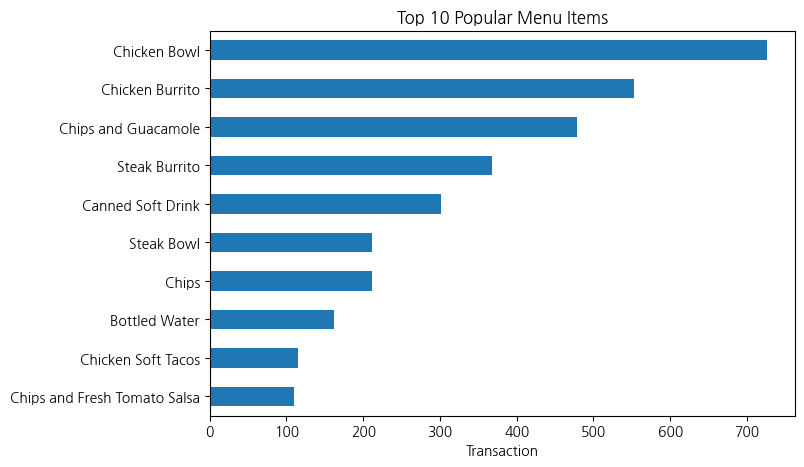

In [ ]:
# 매출 상위 10개 상품 시각화
# 1) sales_quantity.sort_values('Transaction')
#    → 판매량(Transaction)을 기준으로 오름차순 정렬
# 2) .tail(10)
#    → 정렬된 목록의 마지막 10개 = 판매량 TOP 10 메뉴
# 3) ['Transaction']
#    → 그 중 판매량 값만 선택 (Series 형태로 추출)
top_ten = sales_quantity.sort_values('Transaction').tail(10)['Transaction']

# 그래프 전체 크기를 가로 9, 세로 5로 설정
plt.figure(figsize=(9,5))

top_ten.plot.barh(
    xlabel='Transaction',              # x축 라벨 (판매량)
    ylabel='',                         # y축 라벨은 공백 (메뉴 이름이 이미 표시됨)
    title='Top 10 Popular Menu Items'  # 그래프 제목
)
# barh → 가로 막대 그래프(h = horizontal)

# y축 메뉴 이름이 잘리지 않도록 왼쪽 여백을 조금 넓힘
plt.subplots_adjust(left=0.25)

# 그래프 표시
plt.show()

# 🔍 Section 6. 연관분석 (Association Rule Mining)

---

## 🧠 개념 요약
- 고객이 **함께 구매한 항목(Item)** 들을 **트랜잭션 단위**로 묶는다.  
- “Burrito를 산 고객이 Chips도 샀을 확률”과 같은 관계를 찾는다.

---

## ⚙️ 실습 절차
1️⃣ `Transaction`별 `Item`을 리스트로 묶기  
2️⃣ 리스트를 **원-핫 인코딩(One-Hot Encoding)** 형태로 변환  
3️⃣ `apriori()`로 빈발 항목 집합 생성  
4️⃣ `association_rules()`로 연관 규칙 도출

In [ ]:
# 중복 제거 후 트랜잭션별 아이템 리스트 생성
# 1) 필요한 두 컬럼만 선택: Transaction(주문번호), Item(메뉴명)
# 2) drop_duplicates() → 동일한 주문에서 같은 메뉴가 여러 번 적혀 있어도 중복 제거
#    예: Transaction 1001에 'Coke'가 2번 있으면 1번만 남김
temp = df[['Transaction', 'Item']].drop_duplicates()

# 3) Transaction(주문번호) 기준으로 그룹화
# 4) 해당 주문에서 등장한 Item들을 list 형태로 묶기
#    예: 1001 → ['Coke', 'Burger', 'Fries']
temp = temp.groupby('Transaction')['Item'].apply(list)

# 5) 트랜잭션별 아이템 리스트 일부 출력
print("트랜잭션 예시:")
print(temp.head())

트랜잭션 예시:
Transaction
1    [Chips and Fresh Tomato Salsa, Izze, Nantucket...
2                                       [Chicken Bowl]
3                        [Chicken Bowl, Side of Chips]
4                    [Steak Burrito, Steak Soft Tacos]
5                 [Steak Burrito, Chips and Guacamole]
Name: Item, dtype: object


# 트랜잭션 예시 해석하기

아래 출력은 **각 트랜잭션(= 한 번의 주문)** 안에서 고객이 어떤 메뉴들을 함께 주문했는지를 보여준다.

---

## 어떻게 해석하면 될까?

### 🔹 Transaction 1
- 한 고객이 한 번의 주문에서 **Chips and Fresh Tomato Salsa**, **Izze**, **Nantucket** 등을 함께 주문함  
- 즉, 여러 아이템이 동시에 등장한 주문

### 🔹 Transaction 2
- **Chicken Bowl** 하나만 주문한 간단한 케이스

### 🔹 Transaction 3
- **Chicken Bowl + Side of Chips**  
- 두 메뉴가 함께 구매된 주문

### 🔹 Transaction 4
- **Steak Burrito + Steak Soft Tacos**  
- 같은 고객이 동시에 두 메뉴를 주문한 사례

### 🔹 Transaction 5
- **Steak Burrito + Chips and Guacamole**  
- 부리또 + 과카몰리 칩 조합 주문

---

## 한 줄 요약
**이 리스트는 “각 주문(Transaction)에서 고객이 어떤 메뉴들을 함께 구매했는지”를 보여주는 데이터이다.**

장바구니 분석(Association Rule / Apriori)을 수행할 때 가장 핵심이 되는 형태의 데이터이다.


In [ ]:
# 원-핫 인코딩으로 변환 (TransactionEncoder)
# TransactionEncoder()는 리스트 형태의 장바구니 데이터를
# → 머신러닝/통계 분석에 사용하기 좋은 0/1 매트릭스로 변환하는 도구
te = TransactionEncoder()

# te.fit(temp) : 트랜잭션에 등장하는 모든 아이템을 학습(아이템 목록 생성)
# te.transform(temp) : 각 트랜잭션을 0/1 형태로 변환
# 예: ['Steak Burrito', 'Chips'] →
#     Steak Burrito = 1, Chips = 1, 그 외 메뉴 = 0
trans_matrix = te.fit(temp).transform(temp)

# DataFrame 변환
# numpy 배열 형태로 만들어진 0/1 매트릭스를 DataFrame으로 변환
# columns=te.columns_ : 각 열 이름을 '메뉴 이름'으로 설정
basket = pd.DataFrame(trans_matrix, columns=te.columns_)

# 변환된 장바구니 데이터 앞부분 확인
# 각 행 = 하나의 트랜잭션(주문)
# 각 열 = 메뉴 이름
# 값 1 = 해당 메뉴가 주문됨
# 값 0 = 주문되지 않음
print("변환 완료! (0/1 매트릭스 구조)")
basket.head()

변환 완료! (0/1 매트릭스 구조)


,6 Pack Soft Drink,Barbacoa Bowl,Barbacoa Burrito,Barbacoa Crispy Tacos,Barbacoa Salad Bowl,Barbacoa Soft Tacos,Bottled Water,Bowl,Burrito,Canned Soda,...,Steak Crispy Tacos,Steak Salad,Steak Salad Bowl,Steak Soft Tacos,Veggie Bowl,Veggie Burrito,Veggie Crispy Tacos,Veggie Salad,Veggie Salad Bowl,Veggie Soft Tacos
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# ⚡ Section 7. Apriori 알고리즘 — 빈발 항목 집합 생성

---

## 💬 Apriori란?
- **Support(지지도)** 가 일정 기준 이상인 항목 조합만 남기는 알고리즘  
- `min_support` 값을 낮출수록 더 많은 조합이 나옴 (계산량 증가)

| 파라미터 | 설명 | 예시 |
|-----------|-------|------|
| **df** | 원-핫 인코딩된 데이터프레임 | basket |
| **min_support** | 최소 지지도 | 0.01 → 1% 이상 거래에서 함께 나온 항목 |
| **use_colnames** | 실제 아이템 이름 표시 여부 | True |

---

In [ ]:
# Apriori 실행
# apriori() : 장바구니(basket) 데이터에서 자주 등장하는 아이템 조합을 찾는 함수
# df=basket       → 원-핫 인코딩된 0/1 매트릭스를 입력
# min_support=0.01 → 전체 트랜잭션의 1% 이상 등장하는 조합만 찾음
# use_colnames=True → 결과에 아이템 이름(Item) 그대로 표시 (숫자 index 대신)
freq_item = apriori(df=basket, min_support=0.01, use_colnames=True)

print("[빈발 항목 집합] 예시:")
freq_item.head(10)

[빈발 항목 집합] 예시:


,support,itemsets
0,0.029444,(6 Pack Soft Drink)
1,0.033261,(Barbacoa Bowl)
2,0.047983,(Barbacoa Burrito)
3,0.013631,(Barbacoa Soft Tacos)
4,0.083969,(Bottled Water)
5,0.051254,(Canned Soda)
6,0.150491,(Canned Soft Drink)
7,0.036532,(Carnitas Bowl)
8,0.031625,(Carnitas Burrito)
9,0.020720,(Carnitas Soft Tacos)


# 🔗 Section 8. 연관 규칙(Association Rules) 도출

---

## 📈 주요 지표

| 지표 | 의미 | 해석 예시 |
|------|------|------------|
| **support** | 전체 거래 중 해당 규칙이 포함된 비율 | 0.05 → 5%의 거래에서 A, B 동시 구매 |
| **confidence** | A를 샀을 때 B도 함께 산 확률 | 0.8 → A 구매자의 80%가 B도 구매 |
| **lift** | A, B가 독립일 때 대비 몇 배 더 자주 등장 | 1보다 크면 긍정적 연관 |

---

In [ ]:
# 연관 규칙 도출
# association_rules() : Apriori의 빈발항목집합(freq_item)으로부터 연관규칙을 생성하는 함수
# df=freq_item  → Apriori로 찾은 아이템 조합을 입력
# metric='lift' → 연관 규칙을 평가할 기준(metric)으로 'lift'를 사용
# min_threshold=1 → lift 값이 1 이상인 규칙만 필터링 (1 미만은 의미가 약함)
#   ※ lift > 1 : 두 상품이 함께 등장할 확률이 "우연 이상"으로 높다 (강한 관련성)
rules = association_rules(df=freq_item, metric='lift', min_threshold=1)

# 신뢰도 높은 순으로 정렬
# confidence(신뢰도) : A를 사면 B도 살 확률
# 즉 “얼마나 일관성 있게 함께 팔리는가?”를 보여주는 지표
# 높은 confidence일수록 더 신뢰할 수 있는 규칙
rules = rules.sort_values('confidence', ascending=False)

# 상위 10개 규칙 출력
# → 어떤 메뉴 조합이 함께 많이 팔리는지 확인 가능
print("상위 10개 연관 규칙:")
rules.head(10)

상위 10개 연관 규칙:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
37,"(Bottled Water, Chips)",(Chicken Bowl),0.019084,0.335333,0.015267,0.800000,2.385691,1.0,0.008868,3.323337,0.592135,0.045016,0.699098,0.422764
21,(Chips and Tomatillo Red Chili Salsa),(Chicken Bowl),0.025082,0.335333,0.015812,0.630435,1.880028,1.0,0.007402,1.798512,0.480136,0.045886,0.443985,0.338795
44,"(Chips, Canned Soft Drink)",(Chicken Bowl),0.031625,0.335333,0.019084,0.603448,1.799551,1.0,0.008479,1.676118,0.458816,0.054859,0.403383,0.330179
19,(Chips),(Chicken Bowl),0.113413,0.335333,0.066521,0.586538,1.749124,1.0,0.028490,1.607568,0.483072,0.174037,0.377942,0.392456
4,(Bottled Water),(Chicken Bowl),0.083969,0.335333,0.037623,0.448052,1.336142,1.0,0.009465,1.204221,0.274638,0.098571,0.169588,0.280124
36,"(Bottled Water, Chicken Bowl)",(Chips),0.037623,0.113413,0.015267,0.405797,3.578038,1.0,0.011000,1.492061,0.748685,0.112450,0.329786,0.270206
13,(Canned Soft Drink),(Chicken Bowl),0.150491,0.335333,0.060523,0.402174,1.199328,1.0,0.010059,1.111807,0.195642,0.142308,0.100564,0.291331
2,(6 Pack Soft Drink),(Chips and Guacamole),0.029444,0.258451,0.011450,0.388889,1.504688,1.0,0.003841,1.213443,0.345586,0.041420,0.175899,0.216596
11,(Canned Soda),(Steak Burrito),0.051254,0.186478,0.019629,0.382979,2.053751,1.0,0.010071,1.318467,0.540805,0.090000,0.241544,0.244121
49,"(Chips and Guacamole, Canned Soft Drink)",(Chicken Bowl),0.033806,0.335333,0.012541,0.370968,1.106268,1.0,0.001205,1.056651,0.099421,0.035168,0.053613,0.204183


In [ ]:
# 가장 강력한 규칙 1개 자세히 보기
# iloc[0, :] → 첫 번째 규칙의 모든 컬럼 정보 선택
# transpose() → 가로(row) 형태를 세로(column) 형태로 바꿔서 보기 좋게 출력
# 출력되는 정보 예:
#   - antecedents : 규칙의 왼쪽 (A → B 중 A)
#   - consequents : 규칙의 오른쪽 (B)
#   - support     : 전체 거래 중 규칙이 등장하는 비율
#   - confidence  : A가 나오면 B도 나올 확률
#   - lift        : A와 B가 함께 등장할 확률이 우연 이상인지 측정 (1보다 크면 강한 관계)

print("상위 1개 규칙 상세 정보:")
rules.iloc[0, :].transpose()

상위 1개 규칙 상세 정보:


,37
antecedents,"(Bottled Water, Chips)"
consequents,(Chicken Bowl)
antecedent support,0.019084
consequent support,0.335333
support,0.015267
confidence,0.8
lift,2.385691
representativity,1.0
leverage,0.008868
conviction,3.323337


# 🧠 Section 9. 결과 해석 및 응용

---

## 💡 해석 예시
> {Chips} → {Guacamole}  
> confidence = 0.75, lift = 2.1  
> ⇒ Chips를 구매한 고객의 75%는 Guacamole도 함께 구매,  
> ⇒ 두 품목은 독립일 때보다 **2.1배 더 강한 관계**

---

## 🚀 응용 아이디어

| 응용 분야 | 예시 |
|------------|------|
| 💳 마케팅 | “A 구매 시 B 할인” 묶음 상품 추천 |
| 🛍️ 리테일 | 구매 동선 분석 및 상품 배치 최적화 |
| 🍕 외식 산업 | 인기 조합 메뉴 구성 (예: 피자 + 콜라) |
| 🎓 교육 데이터 | 과목 수강 패턴 분석 (통계+데이터사이언스) |
| 🧠 학내 데이터 | 도서관 대출 책 간 연관 규칙 |

---
🎯 **결론 (結)**  
연관분석은 **“데이터 속 숨겨진 연결 관계”** 를 밝혀내는 분석 기법입니다.  
단순히 판매 상위를 보는 것이 아니라,  
상품 간 **상호작용 패턴을 발견**하여 **추천·배치·마케팅 전략**에 활용할 수 있습니다.

# 📘 Section X. 텍스트 데이터 워드클라우드 — 반기문 연설문 분석

---

## 🎯 학습 목표
이번 실습에서는 **자연어 텍스트(.txt)** 데이터를 활용하여  
단어 빈도를 시각화하고 핵심 키워드를 추출합니다.

---

## 💡 실습 개요

| 단계 | 내용 | 주요 함수 |
|------|------|-----------|
| 1️⃣ | 텍스트 파일 불러오기 | `pd.read_fwf()` |
| 2️⃣ | 형태소 분석 (명사 추출) | `konlpy.tag.Kkma()` |
| 3️⃣ | 단어 정제 및 필터링 | `explode()`, `query()` |
| 4️⃣ | 빈도 계산 및 정렬 | `groupby()`, `count()` |
| 5️⃣ | 워드클라우드 시각화 | `WordCloud()` |

---

## ⚙️ Colab 환경 준비
1️⃣ **`반기문_국회_연설문.txt` 파일을 업로드**합니다.  
2️⃣ `konlpy`, `wordcloud`, `matplotlib` 설치 후 한글 폰트 지정.

# 📦 환경 설정 (Colab 실행용)

In [ ]:
!pip install konlpy wordcloud
!apt-get install fonts-nanum* -qq

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import konlpy
import matplotlib.font_manager as fm

# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(path)
plt.rc('font', family='NanumGothic')

print("설치 및 폰트 설정 완료!")

설치 및 폰트 설정 완료!


# 📂 Section 1. 데이터 불러오기

In [ ]:
# Colab에서는 파일 직접 업로드 필요
from google.colab import files
import os

os.makedirs("data", exist_ok=True)
print("[STEP 1] '반기문_국회_연설문.txt' 파일을 업로드하세요.")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f"data/{filename}")

print("파일 업로드 완료!")
!ls data

[STEP 1] '반기문_국회_연설문.txt' 파일을 업로드하세요.


Saving 반기문_국회_연설문.txt to 반기문_국회_연설문.txt
파일 업로드 완료!
chipotle.csv  movie1_review.csv  반기문_국회_연설문.txt


# 📖 Section 2. 텍스트 파일 읽기

In [ ]:
# 텍스트 파일의 구조는 고정폭(fixed width)이므로 read_fwf() 사용
df = pd.read_fwf('data/반기문_국회_연설문.txt').iloc[:, 0]

print("데이터 읽기 완료 — 상위 5개 줄 미리보기:")
df.head()

데이터 읽기 완료 — 상위 5개 줄 미리보기:


,"""유엔과 한국: 함께 이루는 인류의 꿈"""
0,"존경하는 국민 여러분, 존경하는 강창희 국회의장님과 국회의원 여러분, 그리고 주한 ..."
1,"한국과 유엔의 길고 특별한 인연을 생각할 때, 저의 두 번째 임기를 시작하면서 대한..."
2,한국의 눈부신 발전은 유엔과 함께 이루어왔다고 해도 과언이 아닐 것입니다. 한국과 ...
3,유엔의 도움으로 한국은 전쟁의 참상을 극복하고 짧은 기간 동안 놀라운 경제발전과 성...
4,저는 세계 각국을 다닐 때마다 한국의 민주화와 경제개발 경험을 소개하고 있습니다. ...


# 🧠 Section 3. 형태소 분석 및 명사 추출

---

## 💬 개념 정리
- 한국어 문장을 분석하려면 **형태소 분석기**가 필요합니다.  
- KoNLPy의 **Kkma(꼬꼬마)** 분석기는 문장에서 **명사(nouns)** 를 쉽게 추출할 수 있습니다.

예시  
> "지속 가능한 발전을 추구합니다."  
> → ['지속', '발전']  

이 과정을 통해 **핵심 단어(키워드)** 를 걸러낼 수 있습니다.

In [ ]:
okt = Okt()   # Okt 형태소 분석기 객체 생성

# 각 문장에서 명사 추출
nouns = df.apply(okt.nouns)   # 각 행에 대해 명사만 추출
nouns = nouns.explode()       # 리스트 형태 → 세로로 펼쳐서 행 단위로 변환

print("명사 추출 완료 — 일부 예시:")
nouns.head(20)

명사 추출 완료 — 일부 예시:


,"""유엔과 한국: 함께 이루는 인류의 꿈"""
0,존경
0,국민
0,여러분
0,존경
0,강창희
0,국회의장
0,국회의원
0,여러분
0,주한
0,외교


# 🧹 Section 4. 데이터 정제 및 전처리

---

## 📘 정제 규칙
1️⃣ 글자 수가 **2개 미만**인 단어는 제거  
2️⃣ 의미 없는 조사나 단어 제거 가능 (`is`, `것`, `수` 등)  
3️⃣ 모든 단어를 DataFrame으로 관리하여 이후 분석에 활용

In [ ]:
# 글자 수 2개 이상인 단어만 추출
df_word = pd.DataFrame({'word': nouns})
df_word['count'] = df_word['word'].str.len()
df_word = df_word.query('count >= 2')

print("정제된 단어 예시:")
df_word.head(10)

정제된 단어 예시:


,word,count
0,존경,2
0,국민,2
0,여러분,3
0,존경,2
0,강창희,3
0,국회의장,4
0,국회의원,4
0,여러분,3
0,주한,2
0,외교,2


# 📊 Section 5. 단어 빈도 계산 및 정렬

In [ ]:
# 단어별 등장 횟수 집계
# 1) 'word' 컬럼 기준으로 동일한 단어들을 묶음
# 2) .count() → 각 단어가 몇 번 등장했는지 세어 'count' 값으로 저장
#    예: "사운드" 12번 등장 → count = 12
df_word = df_word.groupby('word', as_index=False).count() # groupby 후에도 그룹 기준 컬럼을 인덱스로 쓰지 말고, 일반 컬럼으로 유지해라.

# 등장 횟수(count)가 많은 순(내림차순)으로 정렬
# 가장 많이 등장한 단어를 위쪽에 배치
df_word = df_word.sort_values('count', ascending=False)

print("상위 10개 단어:")
df_word.head(10)

상위 10개 단어:


,word,count
644,한국,74
440,유엔,40
327,세계,37
88,국민,20
393,여러분,20
660,협력,13
93,국제사회,13
92,국제,12
400,역할,12
214,목표,12


# ☁️ Section 6. 워드클라우드 시각화

---

## 🎨 WordCloud 주요 옵션

| 옵션 | 설명 | 예시 |
|------|------|------|
| **font_path** | 한글 폰트 경로 지정 | `/usr/share/fonts/truetype/nanum/NanumGothic.ttf` |
| **width, height** | 이미지 크기 | `width=600, height=600` |
| **background_color** | 배경색 지정 | `'white'`, `'ivory'`, `'black'` |
| **colormap** | 색상 팔레트 | `'plasma'`, `'rainbow'`, `'cool'` |
| **random_state** | 배치 재현성 설정 | `random_state=123` |

---

> 💡 **워드클라우드 생성 절차**
> 1️⃣ 단어-빈도 딕셔너리 생성  
> 2️⃣ `WordCloud()` 객체 생성  
> 3️⃣ `.generate_from_frequencies()`로 이미지 변환  
> 4️⃣ `matplotlib`으로 출력

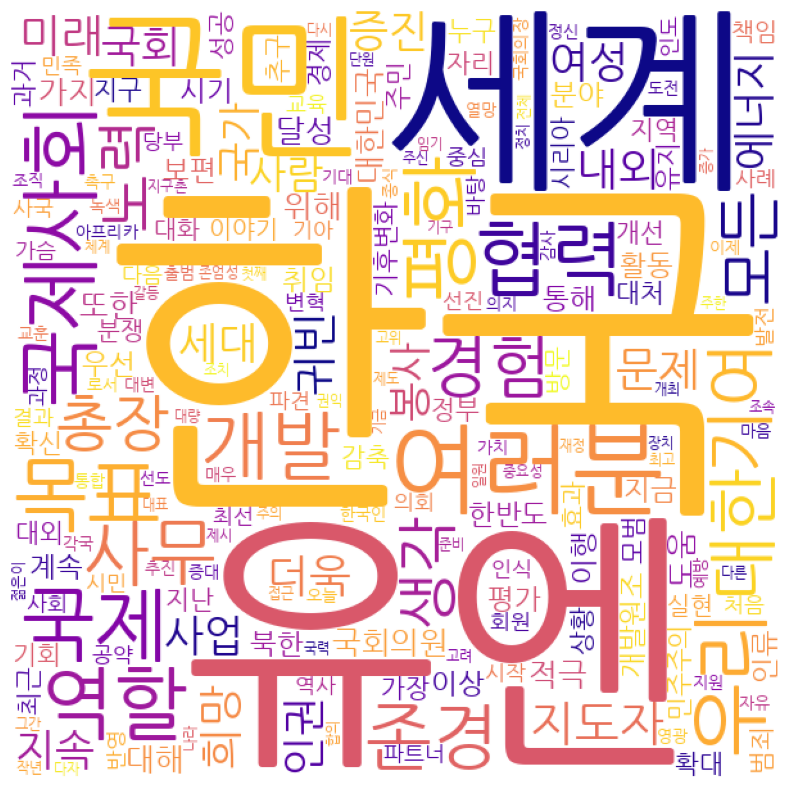

In [ ]:
# 단어-빈도 딕셔너리로 변환
dic_word = df_word.set_index('word').to_dict()['count']

# 워드클라우드 생성
wc = WordCloud(
    random_state=123,
    font_path=path,
    width=600,
    height=600,
    background_color='white',
    colormap='plasma'
)

# 단어 빈도 기반 이미지 생성
img_wordcloud = wc.generate_from_frequencies(dic_word)

# 결과 시각화
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_wordcloud)
plt.show()

# 📊 Section 7. 결과 해석 및 응용

---

## 💬 결과 해석 예시
- 단어가 **클수록 자주 등장**했다는 의미  
- 연설문에서 강조된 핵심 주제나 가치가 시각적으로 드러남  
  예: "평화", "지속", "협력", "발전" 등  

---

## 🚀 확장 아이디어
| 주제 | 응용 방법 |
|------|------------|
| 🎓 학술 연설문 | 정책적 키워드 비교 |
| 🗳️ 정치 연설문 | 화자별 주요 단어 비교 |
| 💬 뉴스 기사 | 분야별 핵심 키워드 추출 |
| 🎬 영화 대사 | 장르별 감정 워드클라우드 |
| 🧠 학생 프로젝트 | 자신이 작성한 보고서/블로그 텍스트 시각화 |

---

🎯 **결론 (結)**  
워드클라우드는 단순한 시각화가 아니라,  
**텍스트 데이터의 주제와 맥락을 시각적으로 드러내는 통찰 도구**입니다.  
연설문·기사·리뷰 등 모든 텍스트 데이터 분석의 출발점이 됩니다.

# 📘 텍스트 마이닝 실습 문제 (기존 코드 범위 내에서만 해결)

아래 문제들은 수업에서 제공된 코드 범위 안에서 **아주 작은 수정만으로** 해결할 수 있도록 구성되어 있습니다.

---

## 🔍 문제 1. 상위 단어 개수를 10개 → 15개로 늘려보세요.
현재 코드는 `df_word.head(10)`을 통해 상위 10개 단어를 출력하고 있습니다.  
이를 **15개로 변경**하여 결과를 확인하세요.

---

## 🔍 문제 2. 단어 길이 필터 기준을 2글자 → 3글자로 바꿔보세요.
`df_word.query('count >= 2')` 부분을 **3글자 이상**으로 변경한 뒤  
상위 10개 단어 결과가 어떻게 달라지는지 확인하세요.

---

## 🔍 문제 3. WordCloud 색상(colormap)을 다른 색상으로 바꿔보세요.
기존 코드에서 `colormap='plasma'`를  
아래 중 하나로 변경해 실행한 뒤 결과를 비교하세요.

- `cool`
- `magma`
- `viridis`

---

## 🔍 문제 4. WordCloud 크기를 변경해보세요.
현재 WordCloud 생성 시 width=600, height=600으로 되어 있습니다.  
이를 **800 × 800**으로 바꾸고 결과를 확인하세요.

---

## 🔍 문제 5. 상위 단어 bar그래프를 만들어보세요.
`df_word.head(10)`으로 상위 단어를 출력하는 대신  
**상위 10개 단어를 bar 그래프로 시각화**하세요.  
(기존 WordCloud 코드 바로 아래에 이어서 작성하면 됩니다.)

---

각 문제는 “기존 코드 1~2줄 수정/추가”만으로 해결할 수 있습니다.

In [ ]:
# 문제 1 & 문제 2
display(df_word.head(15))

df_word['len'] = df_word['word'].str.len()
df_word3 = df_word.query('len >= 3')
display(df_word3.head(10))

,word,count,len
644,한국,74,2
440,유엔,40,2
327,세계,37,2
88,국민,20,2
393,여러분,20,3
660,협력,13,2
93,국제사회,13,4
92,국제,12,2
400,역할,12,2
214,목표,12,2


,word,count,len
393,여러분,20,3
93,국제사회,13,4
555,지도자,9,3
388,에너지,7,3
95,국회의원,6,4
167,대한민국,6,4
29,개발원조,5,4
647,한반도,5,3
126,기후변화,4,4
230,민주주의,4,4


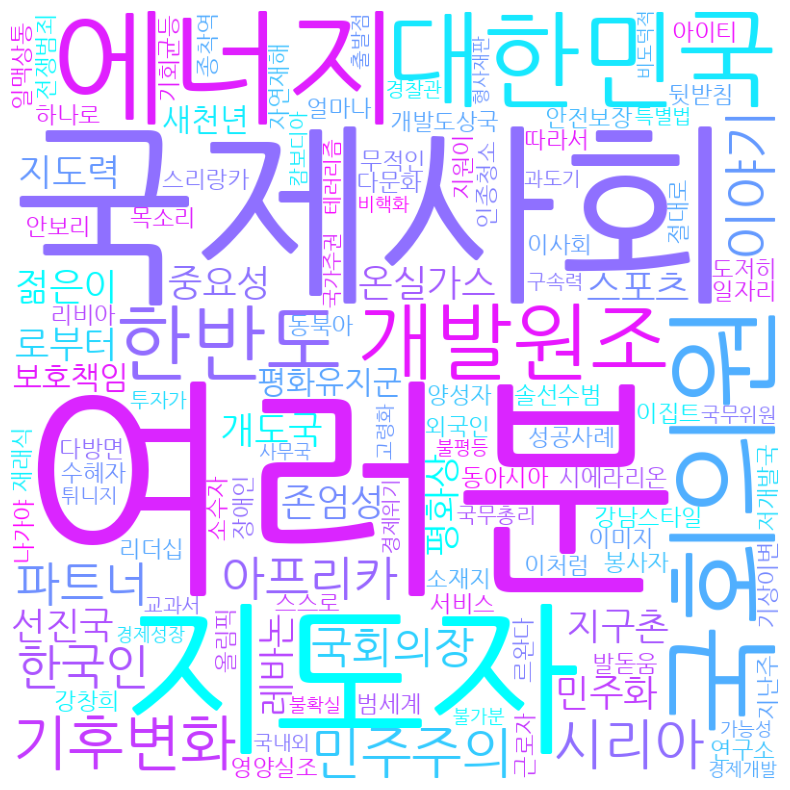

In [ ]:
# 문제 3 & 문제 4
dic_word = df_word3.set_index('word').to_dict()['count']

wc = WordCloud(
    random_state=123,
    font_path=path,
    width=800,
    height=800,
    background_color='white',
    colormap='cool'
)

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_wordcloud)
plt.show()

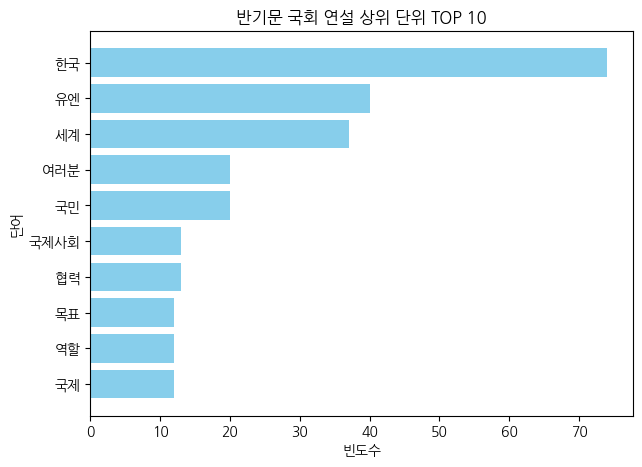

In [ ]:
# 문제 5
import matplotlib.pyplot as plt

df_top10 = df_word.head(10).sort_values("count", ascending=True)

plt.figure(figsize=(7,5))
plt.barh(df_top10["word"], df_top10["count"], color="skyblue")
plt.title("반기문 국회 연설 상위 단위 TOP 10")
plt.xlabel("빈도수")
plt.ylabel("단어")
plt.show()